In [1]:
import sys
sys.path.append('../..')
import subprocess
import argparse
import pickle
import os
from evaluation.scripts.evaluate import create_loaders, eval_model_averages

In [2]:
NETWORK_PATH = '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_conv.pkl'
DATASETS_PATH = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/'


valid_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
new_variance = [1.0, 0.5]

In [3]:
from nflows.utils import torchutils
import torch

results = {1.0 : {
                1 : [83.53643966547193, 83.67980884109917, 89.58183990442055, 95.65113500597371, 54.33691756272402, 24.492234169653525],
                2 : [65.51971326164875, 67.59856630824372, 71.92353643966547, 77.99283154121865, 40.43010752688172, 19.6415770609319],
                4 : [49.82078853046595, 51.70848267622461, 55.794504181600956, 60.04778972520908, 31.756272401433694, 18.30346475507766],
                8 : [47.33572281959379, 48.31541218637993, 50.60931899641577, 55.531660692951014, 29.19952210274791, 16.224611708482676],
                16 : [48.36320191158901, 49.17562724014337, 52.73596176821983, 57.56272401433692, 29.17562724014337, 16.36798088410992],
                32 : [52.49701314217443, 53.09438470728794, 58.27956989247311, 63.058542413381126, 29.629629629629626, 15.985663082437277],
                64 : [57.682198327359615, 58.13620071684588, 65.20908004778973, 68.43488649940262, 32.043010752688176, 16.057347670250895],
                128 : [61.55316606929511, 62.9868578255675, 69.557945041816, 75.62724014336918, 33.62007168458781, 16.79808841099164],
                256 : [64.94623655913978, 65.54360812425328, 74.12186379928315, 79.35483870967742, 33.643966547192356, 16.320191158900837],
                512 : [67.04898446833931, 67.38351254480287, 76.27240143369175, 82.93906810035843, 35.101553166069294, 17.108721624850656],
                1024 : [68.24372759856631, 68.91278375149344, 77.4910394265233, 84.3010752688172, 35.412186379928315, 16.678614097968936],
                2048 : [68.07646356033453, 69.60573476702508, 78.75746714456392, 85.32855436081242, 35.55555555555556, 16.511350059737158],
                4096 : [69.22341696535244, 70.17921146953405, 78.805256869773, 86.06929510155317, 35.6989247311828, 16.678614097968936],
                8192 : [69.1995221027479, 70.37037037037037, 78.6857825567503, 85.80645161290322, 35.722819593787335, 16.654719235364396]
        },
        0.5 : {
                1 : [83.53643966547193, 83.67980884109917, 89.58183990442055, 95.65113500597371, 54.33691756272402, 24.492234169653525],
                2 : [77.2520908004779, 76.86977299880525, 83.7037037037037, 89.89247311827957, 46.88172043010753, 21.50537634408602],
            4 : [62.17443249701314, 61.86379928315412, 68.14814814814815, 73.71565113500597, 37.801672640382314, 18.494623655913976],
            8 : [59.402628434886495, 59.976105137395464, 64.85065710872162, 70.77658303464756, 34.33691756272401, 18.18399044205496],
            16 : [61.505376344086024, 61.62485065710872, 67.6463560334528, 74.09796893667861, 35.3405017921147, 17.44324970131422],
            32 : [64.30107526881721, 65.08960573476702, 71.3978494623656, 76.46356033452808, 35.3405017921147, 16.91756272401434],
            64 : [65.80645161290323, 66.5710872162485, 73.81123058542414, 78.87694145758661, 36.511350059737154, 17.658303464755075],
            128 : [67.98088410991637, 67.67025089605735, 75.02986857825567, 80.11947431302269, 37.41935483870968, 18.16009557945042],
            256 : [68.60215053763442, 68.45878136200717, 75.3405017921147, 81.0752688172043, 37.10872162485065, 18.255675029868577],
            512 : [68.88888888888889, 68.53046594982078, 75.98566308243727, 81.38590203106332, 37.18040621266428, 17.968936678614096],
            1024 : [69.08004778972521, 68.62604540023895, 75.74671445639187, 81.21863799283155, 37.4910394265233, 18.30346475507766],
            2048 : [69.12783751493428, 68.24372759856631, 75.67502986857826, 80.97968936678615, 37.3715651135006, 18.375149342891277],
            4096 : [68.98446833930704, 68.48267622461171, 75.77060931899642, 80.69295101553166, 37.3715651135006, 18.064516129032256],
            8192 : [69.00836320191159, 68.55436081242533, 75.4599761051374, 80.8363201911589, 37.46714456391876, 17.99283154121864],
            
        },
        0.1 : {
              1 : [83.53643966547193, 83.67980884109917, 89.58183990442055, 95.65113500597371, 54.33691756272402, 24.492234169653525],
              2 : [80.59737156511349, 81.36200716845879, 88.2915173237754, 94.81481481481482, 49.41457586618877, 20.477897252090802],
              4 : [76.96535244922342, 77.63440860215054, 84.70728793309439, 91.32616487455198, 45.90203106332139, 18.805256869773],
              8 : [73.88291517323775, 75.00597371565114, 81.00358422939068, 87.09677419354838, 42.986857825567505, 18.112305854241338],
              16 : [70.72879330943847, 71.35005973715651, 77.75388291517324, 83.41696535244922, 41.17084826762246, 18.42293906810036],
              32 : [68.21983273596177, 67.83751493428912, 74.07407407407408, 80.02389486260454, 39.37873357228196, 18.470728793309437],
              64 : [66.52329749103943, 66.95340501792114, 72.52090800477897, 78.0884109916368, 38.3273596176822, 18.661887694145758],
              128 : [65.66308243727599, 66.06929510155317, 72.11469534050178, 77.10872162485066, 37.94504181600956, 18.85304659498208],
              256 : [65.01792114695341, 65.7347670250896, 71.51732377538829, 76.58303464755078, 37.89725209080048, 18.42293906810036],
              512 : [64.68339307048984, 65.28076463560335, 71.11111111111111, 76.48745519713262, 37.873357228195935, 18.51851851851852],
              1024 : [64.80286738351253, 65.44802867383513, 70.89605734767025, 76.12903225806451, 37.443249701314215, 18.59020310633214],
              2048 : [64.51612903225806, 65.42413381123059, 71.13500597371565, 76.08124253285543, 37.34767025089606, 18.661887694145758],
              4096 : [64.58781362007169, 65.47192353643968, 70.89605734767025, 76.00955794504182, 37.41935483870968, 18.6857825567503],
              8192 : [64.54002389486261, 65.40023894862604, 70.94384707287932, 75.91397849462366, 37.29988052568698, 18.70967741935484],
            
        
        }
}

model_file = open(NETWORK_PATH, 'rb')
model = pickle.load(model_file)
model_file.close()
model.cuda()

val_loaders, datasets = create_loaders(DATASETS_PATH)

for var in new_variance:
    if var not in results:
        results[var] = {}
    if var is not None:
        md = model.flow._distribution
        def sample_met(num_samples, context):
            means, log_stds = md._compute_params(context)
            stds = torch.exp(log_stds)
            means = torchutils.repeat_rows(means, num_samples)
            stds = torchutils.repeat_rows(stds, num_samples)
            context_size = context.shape[0]
            noise = torch.randn(context_size * num_samples, *
                            md._shape, device=means.device)
            samples = means + stds * noise * var
            return torchutils.split_leading_dim(samples, [context_size, num_samples])
        md._sample = sample_met

    for val in valid_values:
        if val in results[var]:
            continue
        if val == 1:
            model.use_flow = False
        else:
            model.z_count = val
            model.use_flow = True
        results[var][val] = eval_model_averages(val_loaders, model)
        print(f"{var} : {val} : {results[var][val]}")

/home/macron/Praca Magisterska/Kod/RobOptWUST/data//mixed_next
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Kod/RobOptWUST/data//mixed_rand
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Kod/RobOptWUST/data//only_fg
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Kod/RobOptWUST/data//original
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Kod/RobOptWUST/data//no_fg
==> Preparing dataset ImageNet9..
/home/macron/Praca Magisterska/Kod/RobOptWUST/data//only_bg_t
==> Preparing dataset ImageNet9..


100%|███████████████████████████████████████| 1047/1047 [01:28<00:00, 11.80it/s]


1.0 : 4096 : [69.22341696535244, 70.17921146953405, 78.805256869773, 86.06929510155317, 35.6989247311828, 16.678614097968936]


100%|███████████████████████████████████████| 1047/1047 [02:07<00:00,  8.23it/s]


1.0 : 8192 : [69.1995221027479, 70.37037037037037, 78.6857825567503, 85.80645161290322, 35.722819593787335, 16.654719235364396]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.97it/s]


0.5 : 2 : [77.2520908004779, 76.86977299880525, 83.7037037037037, 89.89247311827957, 46.88172043010753, 21.50537634408602]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.96it/s]


0.5 : 4 : [62.17443249701314, 61.86379928315412, 68.14814814814815, 73.71565113500597, 37.801672640382314, 18.494623655913976]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.92it/s]


0.5 : 8 : [59.402628434886495, 59.976105137395464, 64.85065710872162, 70.77658303464756, 34.33691756272401, 18.18399044205496]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.95it/s]


0.5 : 16 : [61.505376344086024, 61.62485065710872, 67.6463560334528, 74.09796893667861, 35.3405017921147, 17.44324970131422]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.90it/s]


0.5 : 32 : [64.30107526881721, 65.08960573476702, 71.3978494623656, 76.46356033452808, 35.3405017921147, 16.91756272401434]


100%|███████████████████████████████████████| 1047/1047 [01:01<00:00, 16.90it/s]


0.5 : 64 : [65.80645161290323, 66.5710872162485, 73.81123058542414, 78.87694145758661, 36.511350059737154, 17.658303464755075]


100%|███████████████████████████████████████| 1047/1047 [01:02<00:00, 16.81it/s]


0.5 : 128 : [67.98088410991637, 67.67025089605735, 75.02986857825567, 80.11947431302269, 37.41935483870968, 18.16009557945042]


100%|███████████████████████████████████████| 1047/1047 [01:02<00:00, 16.82it/s]


0.5 : 256 : [68.60215053763442, 68.45878136200717, 75.3405017921147, 81.0752688172043, 37.10872162485065, 18.255675029868577]


100%|███████████████████████████████████████| 1047/1047 [01:02<00:00, 16.81it/s]


0.5 : 512 : [68.88888888888889, 68.53046594982078, 75.98566308243727, 81.38590203106332, 37.18040621266428, 17.968936678614096]


100%|███████████████████████████████████████| 1047/1047 [01:02<00:00, 16.80it/s]


0.5 : 1024 : [69.08004778972521, 68.62604540023895, 75.74671445639187, 81.21863799283155, 37.4910394265233, 18.30346475507766]


100%|███████████████████████████████████████| 1047/1047 [01:11<00:00, 14.60it/s]


0.5 : 2048 : [69.12783751493428, 68.24372759856631, 75.67502986857826, 80.97968936678615, 37.3715651135006, 18.375149342891277]


100%|███████████████████████████████████████| 1047/1047 [01:29<00:00, 11.70it/s]


0.5 : 4096 : [68.98446833930704, 68.48267622461171, 75.77060931899642, 80.69295101553166, 37.3715651135006, 18.064516129032256]


100%|███████████████████████████████████████| 1047/1047 [02:07<00:00,  8.19it/s]


0.5 : 8192 : [69.00836320191159, 68.55436081242533, 75.4599761051374, 80.8363201911589, 37.46714456391876, 17.99283154121864]


In [4]:
print(results)

{1.0: {1: [83.53643966547193, 83.67980884109917, 89.58183990442055, 95.65113500597371, 54.33691756272402, 24.492234169653525], 2: [65.51971326164875, 67.59856630824372, 71.92353643966547, 77.99283154121865, 40.43010752688172, 19.6415770609319], 4: [49.82078853046595, 51.70848267622461, 55.794504181600956, 60.04778972520908, 31.756272401433694, 18.30346475507766], 8: [47.33572281959379, 48.31541218637993, 50.60931899641577, 55.531660692951014, 29.19952210274791, 16.224611708482676], 16: [48.36320191158901, 49.17562724014337, 52.73596176821983, 57.56272401433692, 29.17562724014337, 16.36798088410992], 32: [52.49701314217443, 53.09438470728794, 58.27956989247311, 63.058542413381126, 29.629629629629626, 15.985663082437277], 64: [57.682198327359615, 58.13620071684588, 65.20908004778973, 68.43488649940262, 32.043010752688176, 16.057347670250895], 128: [61.55316606929511, 62.9868578255675, 69.557945041816, 75.62724014336918, 33.62007168458781, 16.79808841099164], 256: [64.94623655913978, 65.5

<Figure size 842.4x595.44 with 0 Axes>

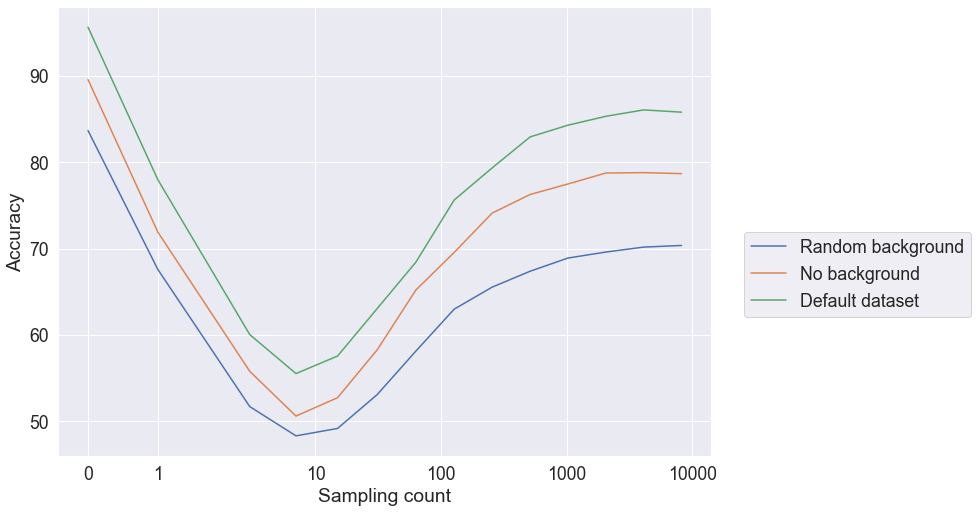

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
pd_results = {'Sampling variance' : [], 'Sampling count' : [], 'Evaluated on' : [], 'Accuracy' : []}
for value in results:
    for z_count in results[value]:
        for dataset, accuracy in zip(datasets, results[value][z_count]):
            pd_results['Sampling variance'].append(value)
            pd_results['Sampling count'].append(z_count - 1)
            pd_results['Evaluated on'].append(dataset.split('/')[-1])
            pd_results['Accuracy'].append(accuracy)
            

                
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="white", context="talk")
sns.set_style("ticks")
sns.despine()
sns.set(font_scale=1.6)
data = pd.DataFrame(pd_results)
p1_data = data[data['Sampling variance'] == 1]
p1_data = p1_data[p1_data['Evaluated on'].isin(['mixed_rand', 'only_fg', 'original'])]
def translate_data(data, dictionary):
    for i, c in enumerate(data):
        for j, d in enumerate(data[c]):
            if d in dictionary:
                data.iloc[j, i] = dictionary[d]
translate_data(p1_data, {'original' : 'Default dataset', 'only_fg' : "No background", 'mixed_rand' : 'Random background'})

f, ax = plt.subplots(figsize=(11.7,8.27))
sns.lineplot(data=p1_data, hue='Evaluated on', x='Sampling count', y='Accuracy', palette="deep", ax=ax)

ax.set_xscale('symlog')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)

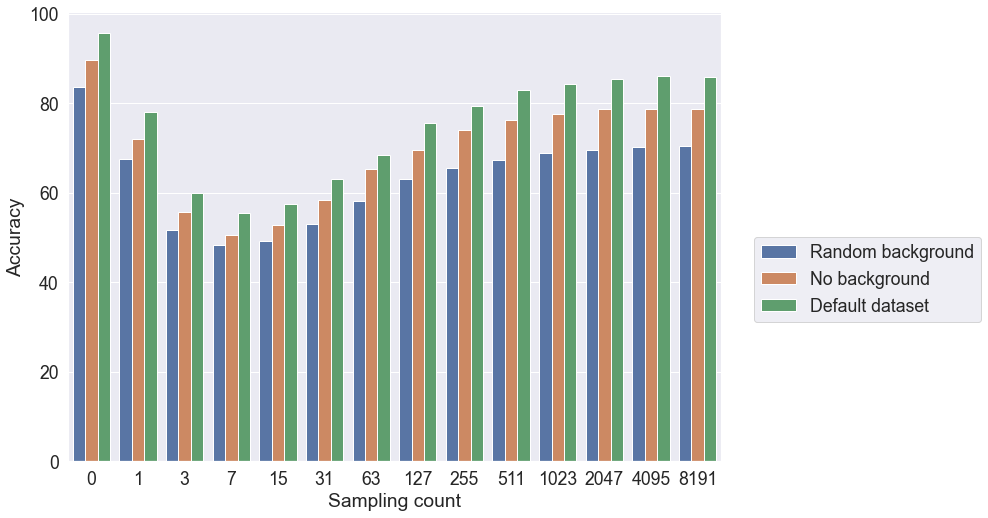

In [33]:
f, ax = plt.subplots(figsize=(11.7,8.27))
sns.barplot(data=p1_data, hue='Evaluated on', x='Sampling count', y='Accuracy', palette="deep", ax=ax)

ax.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)